In [19]:
from glob import glob
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras

In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import os

class TCRDataLoader:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.aa_dict = None
        self.v_dict = None
        self.j_dict = None
        self.label_map = None
        self.max_length = None
        
    def combine_columns(self, df, column_variants, new_column_name):
        """Combine multiple columns that represent the same data type"""
        combined_series = pd.Series([None] * len(df), index=df.index)
        
        for variant in column_variants:
            if variant in df.columns:
                # Fill in non-null values from this column
                mask = df[variant].notna() & combined_series.isna()
                combined_series[mask] = df[variant][mask]
                print(f"  Added {mask.sum()} values from '{variant}' column")
        
        return combined_series
    
    def load_files(self):
        df_list = []
        files = glob(self.data_dir + "/*/*.tsv")
        
        for file_path in files:
            df = pd.read_csv(file_path, sep='\t')
            
            # Extract folder name from file path
            folder_name = os.path.basename(os.path.dirname(file_path))
            
            # Split folder name to get Antigen
            parts = folder_name.split('-')
            antigen = parts[-1]  # Get last part (the antigen)
            
            # Add antigen column to dataframe
            df['Antigen'] = antigen
            
            df_list.append(df)
        
        combined_df = pd.concat(df_list, ignore_index=True)
        
        # Define column candidates for each data type
        column_variants = {
            'sequence': ['aminoAcid', 'beta', 'Amino', 'sequence', 'cdr3', 'CDR3'],
            'v_gene': ['v_beta', 'vGeneName', 'v_gene', 'V_gene', 'TRBV'],
            'j_gene': ['j_beta', 'jGeneName', 'j_gene', 'J_gene', 'TRBJ'],
            'counts': ['counts', 'count', 'count (templates/reads)', 'templates', 'reads', 'frequency']
        }
        
        print("Combining columns:")
        # Combine columns for each data type
        for standard_name, variants in column_variants.items():
            print(f"\nCombining {standard_name} columns:")
            combined_series = self.combine_columns(combined_df, variants, standard_name)
            combined_df[f'combined_{standard_name}'] = combined_series
            
            # Show statistics
            total_values = combined_series.notna().sum()
            print(f"  Total combined values: {total_values}")
        
        return combined_df
    
    def build_vocabulary(self, df):
        # Use combined columns
        # Amino acids
        all_sequences = df['combined_sequence'].dropna()
        if len(all_sequences) == 0:
            raise ValueError("No sequence data found in combined columns!")
            
        giant_string = ''.join(all_sequences)
        unique_letters = sorted(set(giant_string))
        self.aa_dict = {}
        for i, letter in enumerate(unique_letters):
            self.aa_dict[letter] = i+1
        
        # V genes
        v_genes = df['combined_v_gene'].dropna().unique()
        v_genes = sorted(v_genes)
        self.v_dict = {}
        for i, gene in enumerate(v_genes):
            self.v_dict[gene] = i + 1

        # J genes
        j_genes = df['combined_j_gene'].dropna().unique()
        j_genes = sorted(j_genes)
        self.j_dict = {}
        for i, gene in enumerate(j_genes):
            self.j_dict[gene] = i + 1

        # Labels
        antigens = df['Antigen'].unique()
        self.label_map = {}
        for i, antigen in enumerate(sorted(antigens)):
            self.label_map[antigen] = i

        # Max length
        sequence_lengths = [len(seq) for seq in df['combined_sequence'].dropna()]
        self.max_length = max(sequence_lengths) if sequence_lengths else 0
        
        print(f"\nVocabulary built:")
        print(f"  Amino acids: {len(self.aa_dict)} unique")
        print(f"  V genes: {len(self.v_dict)} unique")
        print(f"  J genes: {len(self.j_dict)} unique")
        print(f"  Max sequence length: {self.max_length}")
    
    def encode_sequences(self, sequences):
        encoded_aa = []
        for sequence in sequences:
            sequence_numbers = []
            for letter in sequence:
                number = self.aa_dict.get(letter, 0)
                sequence_numbers.append(number)
            # Add padding zeros if sequence is shorter than max_length
            while len(sequence_numbers) < self.max_length:
                sequence_numbers.append(0)
            encoded_aa.append(sequence_numbers)
        return encoded_aa
    
    def encode_v_genes(self, v_genes):
        encoded_v = []
        for v_gene in v_genes:
            encoded_v.append(self.v_dict.get(v_gene, 0))
        return encoded_v
    
    def encode_j_genes(self, j_genes):
        encoded_j = []
        for j_gene in j_genes:
            encoded_j.append(self.j_dict.get(j_gene, 0))
        return encoded_j
    
    def load_and_encode_data(self, batch_size=100, shuffle=True):
        # 1. Load files and combine columns
        df = self.load_files()
        
        # 2. Build vocabularies
        self.build_vocabulary(df)
        
        # 3. Filter out rows with missing amino acid sequences
        valid_rows = df['combined_sequence'].notna()
        df_valid = df[valid_rows].copy()
        
        print(f"Valid data: {len(df_valid)} out of {len(df)} total rows")
        
        # 4. Get the data you want to encode (now all valid)
        sequences = df_valid['combined_sequence'].values
        v_genes = df_valid['combined_v_gene'].fillna('UNK').values
        j_genes = df_valid['combined_j_gene'].fillna('UNK').values
        labels = [self.label_map[antigen] for antigen in df_valid['Antigen']]
        
        # 5. Encode everything
        X_sequences = self.encode_sequences(sequences)
        X_v_genes = self.encode_v_genes(v_genes)
        X_j_genes = self.encode_j_genes(j_genes)
        
        # 6. Convert to numpy arrays
        X_sequences = np.array(X_sequences)
        X_v_genes = np.array(X_v_genes)
        X_j_genes = np.array(X_j_genes)
        y_labels = np.array(labels)
        
        # 7. Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices((
            {'cdr3_sequence': X_sequences, 'v_gene': X_v_genes, 'j_gene': X_j_genes,},
            {'labels': y_labels}
        ))
            
        # Map to the format expected by the model
        dataset = dataset.map(lambda X, y: (X, {'labels': tf.one_hot(y['labels'], len(self.label_map))}))
            
        if shuffle:
            dataset = dataset.shuffle(len(X_sequences), reshuffle_each_iteration=True)
        
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset
    
    def get_vocab_sizes(self):
        """Return vocabulary sizes for model construction"""
        return {
            'aa_vocab_size': len(self.aa_dict) + 1,  # +1 for padding
            'v_vocab_size': len(self.v_dict) + 1,    # +1 for unknown
            'j_vocab_size': len(self.j_dict) + 1,    # +1 for unknown
            'num_classes': len(self.label_map),
            'max_length': self.max_length
        }
    
    def get_mappings(self):
        """Return the created mappings for inspection"""
        return {
            'aa_dict': self.aa_dict,
            'v_dict': self.v_dict,
            'j_dict': self.j_dict,
            'label_map': self.label_map
        }

In [21]:
def create_tcr_model(vocab_sizes):
    """Create a model using the Conv1D architecture from the reference"""
    # Input layers
    cdr3_input = keras.Input(shape=(vocab_sizes['max_length'],), dtype=tf.uint32, name='cdr3_sequence')
    
    # CDR3 sequence encoder (following the reference structure)
    cdr3_embed = keras.layers.Embedding(
        input_dim=vocab_sizes['aa_vocab_size'], 
        output_dim=8, 
        mask_zero=True
    )(cdr3_input)
    
    convs = [keras.layers.Conv1D(
        filters=16, 
        kernel_size=9, 
        strides=1, 
        activation=keras.activations.relu,
        padding='valid'
    )(cdr3_embed)]
    
    convs.append(keras.layers.Conv1D(
        filters=32, 
        kernel_size=7, 
        strides=2, 
        activation=keras.activations.relu,
        padding='valid'
    )(convs[-1]))
    
    # convs.append(keras.layers.Conv1D(
    #     filters=256, 
    #     kernel_size=5, 
    #     strides=1, 
    #     activation=None,
    #     padding='valid'
    # )(convs[-1]))
    
    # Take the first position output (like in reference: [:, 0, :])
    # cdr3_encoded = convs[-1][:, 0, :]

    # pooling to gain positional equivariance
    cdr3_encoded = keras.layers.GlobalMaxPooling1D()(convs[-1])
    
    # Gene embeddings

    # Flatten gene embeddings
    # v_flat = tf.keras.layers.Flatten()(v_embed)
    # j_flat = tf.keras.layers.Flatten()(j_embed)
    
    # Concatenate all features
    fused = keras.layers.Concatenate(axis=-1)([cdr3_encoded])
    
    # Classifier (following reference structure)
    dropout1 = keras.layers.Dropout(rate=0.1)(fused)
    dense1 = keras.layers.Dense(units=32, activation=keras.activations.relu)(dropout1)
    dropout2 = keras.layers.Dropout(rate=0.05)(dense1)
    dense2 = keras.layers.Dense(units=16, activation=keras.activations.relu)(dropout2)
    # output = tf.keras.layers.Dense(units=vocab_sizes['num_classes'], activation='softmax')(dense2)
    output = keras.layers.Dense(units=vocab_sizes['num_classes'], activation='sigmoid')(dense2)

    model = keras.Model(
        inputs=[cdr3_input],
        outputs=output
    )
    
    return model

In [22]:
# Initialize loader
data_dir = './DeepTCR/Data/Murine_Antigens'
loader = TCRDataLoader(data_dir)

# Load data
print("Loading data...")
dataset = loader.load_and_encode_data(batch_size=100, shuffle=True)
print("Data loaded successfully!")


Loading data...
Combining columns:

Combining sequence columns:
  Added 1753 values from 'aminoAcid' column
  Added 1924 values from 'beta' column
  Total combined values: 3677

Combining v_gene columns:
  Added 1924 values from 'v_beta' column
  Added 3678 values from 'vGeneName' column
  Total combined values: 5602

Combining j_gene columns:
  Added 1924 values from 'j_beta' column
  Added 3670 values from 'jGeneName' column
  Total combined values: 5594

Combining counts columns:
  Added 1924 values from 'counts' column
  Added 3679 values from 'count (templates/reads)' column
  Total combined values: 5603

Vocabulary built:
  Amino acids: 21 unique
  V genes: 42 unique
  J genes: 14 unique
  Max sequence length: 19
Valid data: 3677 out of 5603 total rows
Data loaded successfully!


In [6]:
loader.v_dict

{'TCRBV01-01': 1,
 'TCRBV02-01': 2,
 'TCRBV03-01': 3,
 'TCRBV04-01': 4,
 'TCRBV05-01': 5,
 'TCRBV05-04': 6,
 'TCRBV06-01': 7,
 'TCRBV07-01': 8,
 'TCRBV08-01': 9,
 'TCRBV09-01': 10,
 'TCRBV10-01': 11,
 'TCRBV11-01': 12,
 'TCRBV12-01': 13,
 'TCRBV12-02': 14,
 'TCRBV12-03': 15,
 'TCRBV13-01': 16,
 'TCRBV13-02': 17,
 'TCRBV13-03': 18,
 'TCRBV13-04': 19,
 'TCRBV14-01': 20,
 'TCRBV15-01': 21,
 'TCRBV16-01': 22,
 'TCRBV17-01': 23,
 'TCRBV18-01': 24,
 'TCRBV19-01': 25,
 'TCRBV19-03': 26,
 'TCRBV20-01': 27,
 'TCRBV20-02': 28,
 'TCRBV21-01': 29,
 'TCRBV22-01': 30,
 'TCRBV23-01': 31,
 'TCRBV24-01': 32,
 'TCRBV24-02': 33,
 'TCRBV25-01': 34,
 'TCRBV26-01': 35,
 'TCRBV27-01': 36,
 'TCRBV28-01': 37,
 'TCRBV29-01': 38,
 'TCRBV29-02': 39,
 'TCRBV30-01': 40,
 'TCRBV31-01': 41,
 'TCRBV31-02': 42}

In [7]:
# Initialize loader
#data_dir = './DeepTCR/Data/Human_Antigens'
#loader = TCRDataLoader(data_dir)

# Load data
#print("Loading data...")
#dataset = loader.load_and_encode_data(batch_size=100, shuffle=True)
#print("Data loaded successfully!")

In [23]:
# Create model
vocab_sizes = loader.get_vocab_sizes()
print("Creating model...")
model = create_tcr_model(vocab_sizes)

# Compile model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

initial_weights = model.get_weights()

# Display model summary
model.summary()

Creating model...


c:\Users\huang\miniconda3\envs\gpu-ml-base\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cdr3_sequence (InputLayer)      │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 19, 8)          │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 11, 16)         │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 32)          │         3,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate (Concatenate)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,697 (26.16 KB)

 Trainable params: 6,697 (26.16 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Updated data preparation using combined columns
df = loader.load_files()
df['Antigen'] = df['Antigen'].astype('category')
loader.build_vocabulary(df)

# Filter valid data using combined columns
valid_rows = df['combined_sequence'].notna()
df_valid = df[valid_rows].copy()

print(f"Valid sequences: {len(df_valid)} out of {len(df)} total")

# Encode data using combined columns
sequences = df_valid['combined_sequence'].values
counts = df_valid['combined_counts'].fillna(1).values  

labels = [loader.label_map[antigen] for antigen in df_valid['Antigen']]

X_sequences = loader.encode_sequences(sequences)

# Convert to numpy
X_sequences = np.array(X_sequences)

# Set up data for cross-validation
X = [
    np.array(X_sequences, dtype=np.int32),
]
y_true = np.array(df_valid['Antigen'].cat.codes.values, dtype=np.int32)

print(f"Final data shapes:")
print(f"  X[0] (sequences): {X[0].shape}")
print(f"  y_true: {y_true.shape}")

Combining columns:

Combining sequence columns:
  Added 1753 values from 'aminoAcid' column
  Added 1924 values from 'beta' column
  Total combined values: 3677

Combining v_gene columns:
  Added 1924 values from 'v_beta' column
  Added 3678 values from 'vGeneName' column
  Total combined values: 5602

Combining j_gene columns:
  Added 1924 values from 'j_beta' column
  Added 3670 values from 'jGeneName' column
  Total combined values: 5594

Combining counts columns:
  Added 1924 values from 'counts' column
  Added 3679 values from 'count (templates/reads)' column
  Total combined values: 5603

Vocabulary built:
  Amino acids: 21 unique
  V genes: 42 unique
  J genes: 14 unique
  Max sequence length: 19
Valid sequences: 3677 out of 5603 total
Final data shapes:
  X[0] (sequences): (3677, 19)
  y_true: (3677,)


C:\Users\huang\AppData\Local\Temp\ipykernel_13292\3337133004.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  counts = df_valid['combined_counts'].fillna(1).values


In [25]:
np.unique(df['aminoAcid'].astype('category').cat.codes.values)

array([  -1,    0,    1, ..., 1307, 1308, 1309],
      shape=(1311,), dtype=int16)

In [26]:
from utils import KerasCrossValidation

In [27]:
df_valid

,beta,counts,v_beta,j_beta,Antigen,aminoAcid,count (templates/reads),vGeneName,jGeneName,combined_sequence,combined_v_gene,combined_j_gene,combined_counts
0,CASRTGATGQLYF,1.0,TCRBV19-03,TCRBJ02-02,F2,NaN,NaN,NaN,NaN,CASRTGATGQLYF,TCRBV19-03,TCRBJ02-02,1.0
1,CASRPDISYNSPLYF,1.0,TCRBV19-03,TCRBJ01-06,F2,NaN,NaN,NaN,NaN,CASRPDISYNSPLYF,TCRBV19-03,TCRBJ01-06,1.0
2,CAIGSNQDTQYF,1.0,TCRBV14-01,TCRBJ02-05,F2,NaN,NaN,NaN,NaN,CAIGSNQDTQYF,TCRBV14-01,TCRBJ02-05,1.0
3,CASSIGQDEQYF,1.0,TCRBV19-01,TCRBJ02-07,F2,NaN,NaN,NaN,NaN,CASSIGQDEQYF,TCRBV19-01,TCRBJ02-07,1.0
4,CASSLFQIQDTQYF,1.0,TCRBV29-01,TCRBJ02-05,F2,NaN,NaN,NaN,NaN,CASSLFQIQDTQYF,TCRBV29-01,TCRBJ02-05,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,NaN,NaN,NaN,NaN,TRP2,CTCSAGWGVYEQYF,1.0,TCRBV01-01,TCRBJ02-07,CTCSAGWGVYEQYF,TCRBV01-01,TCRBJ02-07,1.0
5597,NaN,NaN,NaN,NaN,TRP2,RSRSIWANTEVFF,1.0,TCRBV20-01,TCRBJ01-01,RSRSIWANTEVFF,TCRBV20-01,TCRBJ01-01,1.0
5600,NaN,NaN,NaN,NaN,TRP2,GCGLGEGTNTEVFF,1.0,TCRBV18-01,TCRBJ01-01,GCGLGEGTNTEVFF,TCRBV18-01,TCRBJ01-01,1.0
5601,NaN,NaN,NaN,NaN,TRP2,VVQHGDSPNTEVFF,1.0,TCRBV08-01,TCRBJ01-01,VVQHGDSPNTEVFF,TCRBV08-01,TCRBJ01-01,1.0


In [28]:
df_valid['combined_sequence']


0         CASRTGATGQLYF
1       CASRPDISYNSPLYF
2          CAIGSNQDTQYF
3          CASSIGQDEQYF
4        CASSLFQIQDTQYF
             ...       
5595     CTCSAGWGVYEQYF
5597      RSRSIWANTEVFF
5600     GCGLGEGTNTEVFF
5601     VVQHGDSPNTEVFF
5602    RSIAHDTISNERLFF
Name: combined_sequence, Length: 3677, dtype: object

In [29]:
df_valid['combined_v_gene']


0       TCRBV19-03
1       TCRBV19-03
2       TCRBV14-01
3       TCRBV19-01
4       TCRBV29-01
           ...    
5595    TCRBV01-01
5597    TCRBV20-01
5600    TCRBV18-01
5601    TCRBV08-01
5602    TCRBV15-01
Name: combined_v_gene, Length: 3677, dtype: object

In [15]:
df_valid['combined_j_gene']


0       TCRBJ02-02
1       TCRBJ01-06
2       TCRBJ02-05
3       TCRBJ02-07
4       TCRBJ02-05
           ...    
5595    TCRBJ02-07
5597    TCRBJ01-01
5600    TCRBJ01-01
5601    TCRBJ01-01
5602    TCRBJ01-04
Name: combined_j_gene, Length: 3677, dtype: object

In [30]:
# set data
X = [
        np.array(X_sequences, dtype=np.int32),
    ]
y_true = np.array(y_true, dtype=np.int32)


In [32]:
X[0]

array([[ 3,  2, 17, ...,  0,  0,  0],
       [ 3,  2, 17, ...,  0,  0,  0],
       [ 3,  2,  9, ...,  0,  0,  0],
       ...,
       [ 7,  3,  7, ...,  0,  0,  0],
       [19, 19, 15, ...,  0,  0,  0],
       [16, 17,  9, ...,  0,  0,  0]], shape=(3677, 19), dtype=int32)

In [33]:
import os

num_repeats = 1

# Create directory structure for saving models
for repeat in range(num_repeats):
    save_dir = f'./samlogs/fit-{repeat:02d}'
    os.makedirs(save_dir, exist_ok=True)
    print(f"Created directory: {save_dir}")

# Now run your CV loop
y_pred_all = []
y_test_all = []
history_all = []

for repeat in range(num_repeats):
    print(f"Running CV repeat {repeat + 1}/{num_repeats}")

    model.set_weights(initial_weights)

    keras_cv = KerasCrossValidation(X=X, y=y_true, keras_model=model, 
                                    save_filepath=f'./samlogs/fit-{repeat:02d}')
    
    y_pred, y_test, history = keras_cv(n_splits=7, batch_size=500, min_epochs=5, 
                                       patience=30, max_epochs=500, training_repeat=2)
    
    y_pred_all.append(y_pred)
    y_test_all.append(y_test)
    history_all.append(history)

Created directory: ./samlogs/fit-00
Running CV repeat 1/1
Epoch 1/500


c:\Users\huang\miniconda3\envs\gpu-ml-base\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['cdr3_sequence']. Received: the structure of inputs=('*',)
  warnings.warn(
c:\Users\huang\miniconda3\envs\gpu-ml-base\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.1641 - loss: 0.6850 - val_accuracy: 0.1749 - val_loss: 0.6450
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1774 - loss: 0.6149 - val_accuracy: 0.1749 - val_loss: 0.4921
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1779 - loss: 0.4781 - val_accuracy: 0.1749 - val_loss: 0.4368
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1757 - loss: 0.4311 - val_accuracy: 0.1749 - val_loss: 0.3878
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1778 - loss: 0.3837 - val_accuracy: 0.1749 - val_loss: 0.3439
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2168 - loss: 0.3466 - val_accuracy: 0.4068 - val_loss: 0.3222
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3159 - loss: 0.3278 - val_accuracy: 0.4183 - val_loss: 0.3097
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3560 - loss: 0.3151 - val_accuracy: 0.4183 - val_loss: 0.

In [34]:
y_pred_all = np.array(y_pred_all)
y_test_all = np.array(y_test_all)

y_pred_mean = np.mean(y_pred_all, axis=0)  
y_pred_median = np.median(y_pred_all, axis=0)  

y_test_representative = y_test_all[0]

In [35]:
import matplotlib.pyplot as plt
from utils import plot_classification_performance

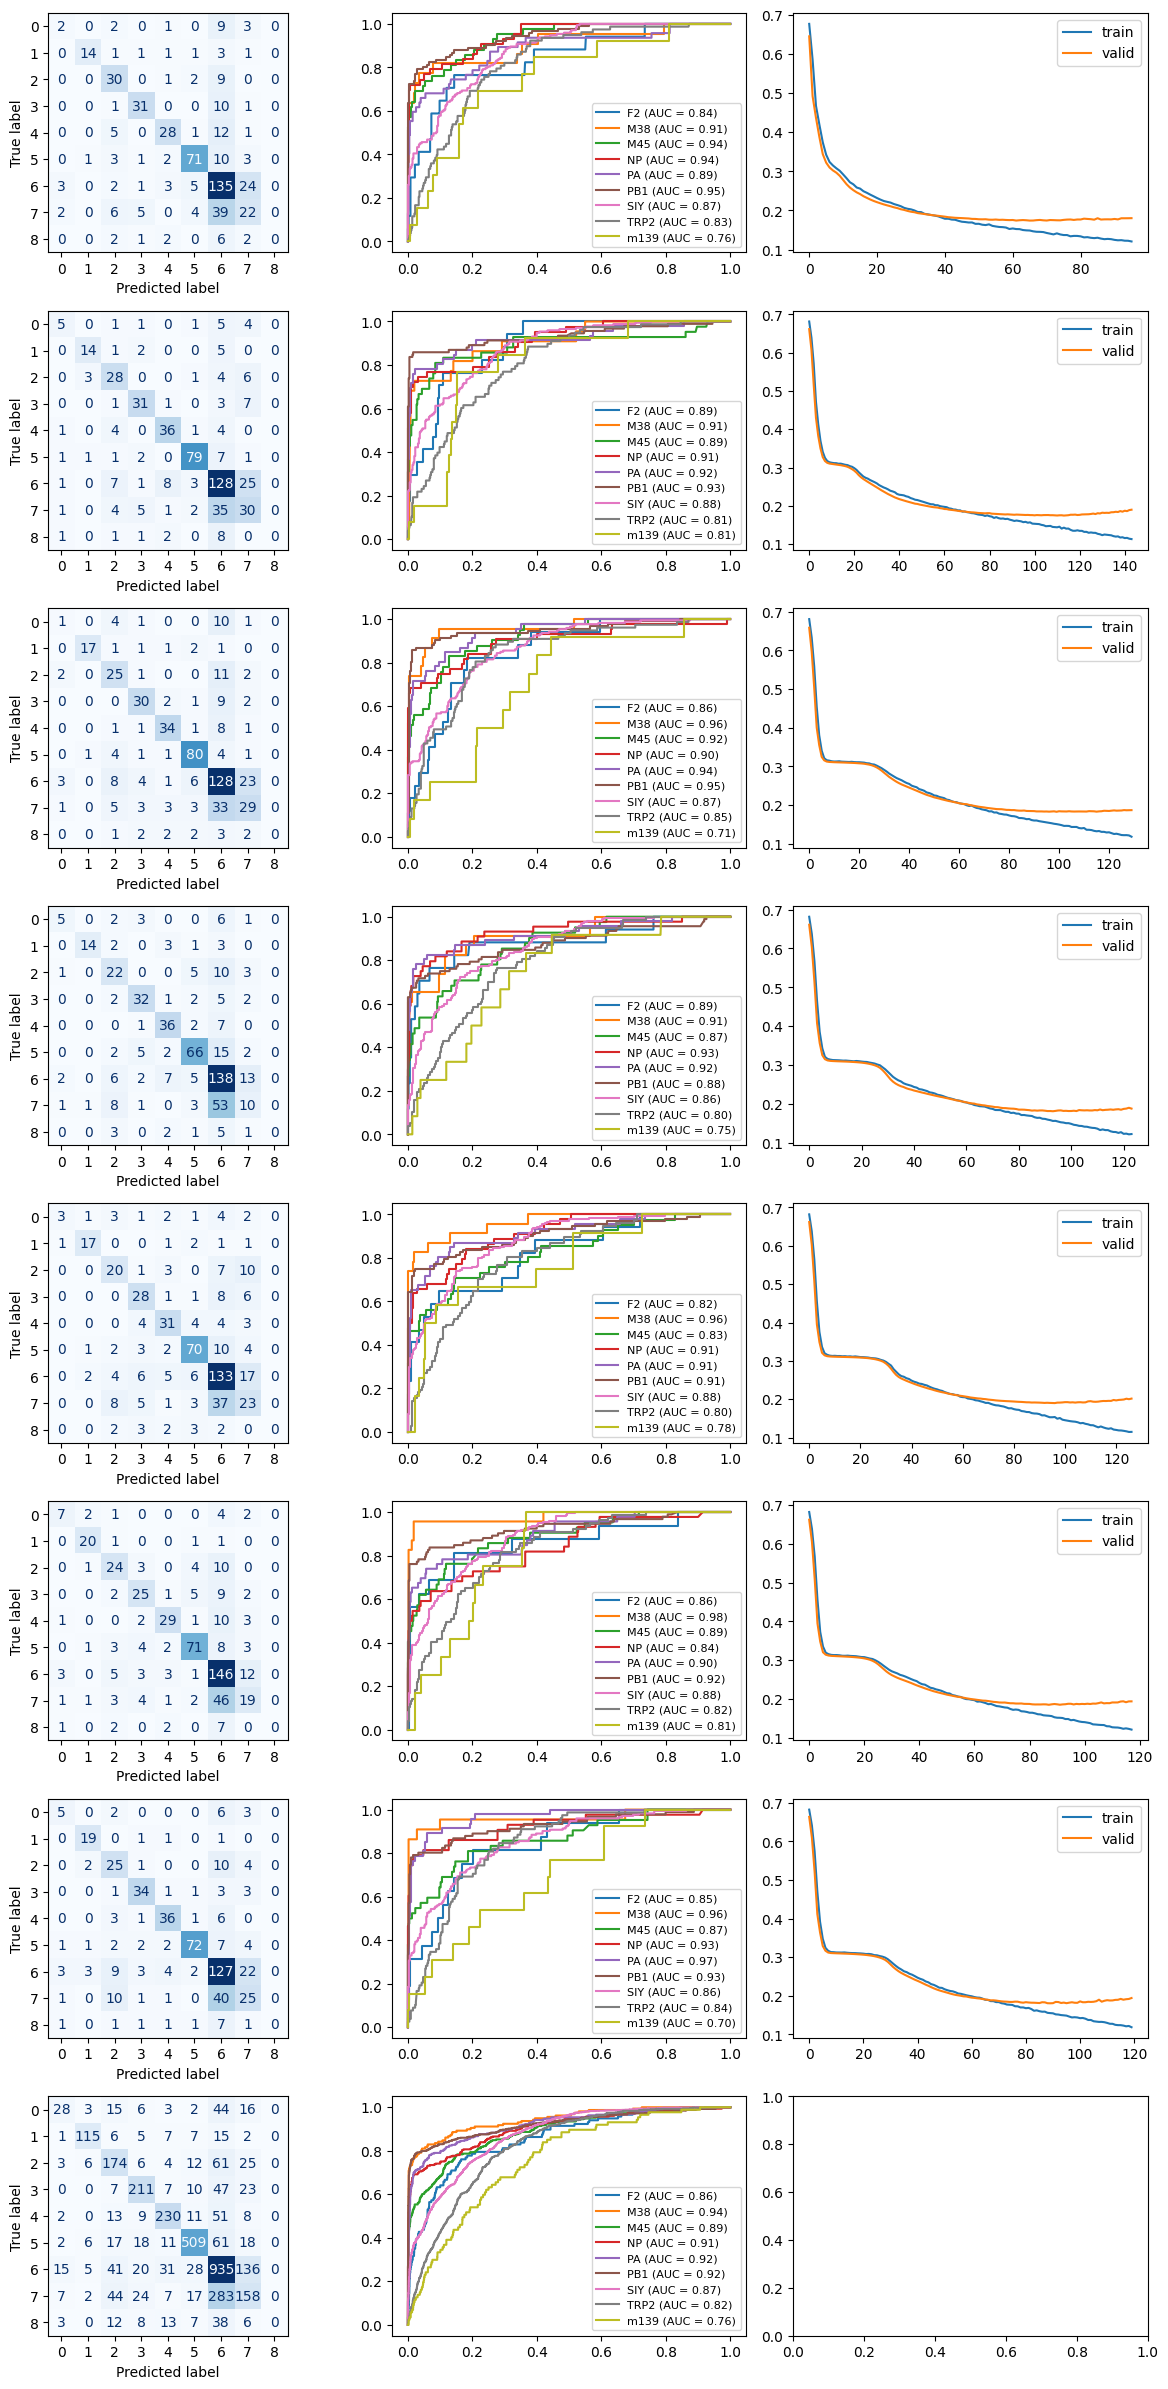

In [36]:
# Plot using the averaged predictions
f, axs = plt.subplots(8, 3, figsize=(12, 3 * 8))

# Plot individual fold results using MEAN predictions
for i in range(7):
    plot_classification_performance(
        axs[i, :],
        y_true[y_test_representative[:, i]],
        y_pred_mean[y_test_representative[:, i], :],
        history_all[0][i],  # Use history from first repeat
        class_names=list(loader.label_map.keys())
    )

# Plot overall results
plot_classification_performance(
    axs[-1, :],
    y_true,
    y_pred_mean,  # Use averaged predictions
    class_names=list(loader.label_map.keys())
)

plt.tight_layout()
plt.show()

In [19]:
import seaborn as sns
from sklearn.metrics import roc_auc_score

# Compute AUC scores for each repeat and each fold individually
num_repeats = y_pred_all.shape[0]  # 50 repeats
n_classes = y_pred_all.shape[-1]   # 10 antigens
n_folds = y_test_all.shape[2]      # 7 folds

auc_scores = []  # will collect all individual AUC scores
antigen_names = list(loader.label_map.keys())

print(f"Computing AUC scores for {num_repeats} repeats × {n_folds} folds × {n_classes} classes...")

for repeat in range(num_repeats):
    for fold in range(n_folds):
        # Get test indices for this fold
        test_indices = y_test_all[repeat, :, fold]
        
        for class_idx in range(n_classes):
            # Create binary labels: 1 if sample belongs to this antigen and 0 otherwise
            y_true_binary = (y_true[test_indices] == class_idx).astype(int)
            y_pred_probs = y_pred_all[repeat, test_indices, class_idx]
            
            try:
                auc_val = roc_auc_score(y_true_binary, y_pred_probs)
            except Exception as e:
                print(f"Error computing roc_auc_score for antigen {class_idx}, repeat {repeat}, fold {fold}: {e}")
                auc_val = np.nan
            
            auc_scores.append({
                'Antigen': antigen_names[class_idx],
                'AUC': auc_val,
                'Method': 'Sup-Seq-VDJ',
                'Repeat': repeat,
                'Fold': fold
            })

plot_df = pd.DataFrame(auc_scores)

# Remove any NaN values
plot_df = plot_df.dropna(subset=['AUC'])

print(f"Total AUC scores collected: {len(plot_df)}")
print(f"Expected: {num_repeats * n_folds * n_classes} (50 × 7 × 10)")
print(f"AUC scores per antigen: {len(plot_df) // n_classes}")

# Create the violin plot using all individual fold AUC scores
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=plot_df, 
    x="Antigen", 
    y="AUC", 
    hue="Method", 
    inner="box", 
    palette=["orange"],  # Set to orange
    scale="area"  # Makes the violins thinner
)
plt.xticks(rotation=45)
plt.ylim(0.50, 1.00)
plt.yticks(np.arange(0.50, 1.05, 0.05))  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Antigen Classification Performance (All CV Folds)")
plt.ylabel("AUC")
plt.xlabel("Antigen")
plt.legend(title="Method", loc="center left", bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.tight_layout()
plt.show()

# Print summary statistics per antigen
print("\nSummary statistics per antigen:")
summary_stats = plot_df.groupby('Antigen')['AUC'].agg(['mean', 'std', 'min', 'max', 'count'])
print(summary_stats)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
plot_df = pd.DataFrame(auc_scores)

# Remove any NaN values
plot_df = plot_df.dropna(subset=['AUC'])

print(f"Total AUC scores collected: {len(plot_df)}")
print(f"Expected: {num_repeats * n_folds * n_classes} (50 × 7 × 10)")
print(f"AUC scores per antigen: {len(plot_df) // n_classes}")

# Define the desired order for antigens
antigen_order = ['Db-F2', 'Db-M45', 'Db-NP', 'Db-PA', 'Db-PB1', 
                 'Kb-M38', 'Kb-SIY', 'Kb-TRP2', 'Kb-m139']

# Convert Antigen column to categorical with specified order
plot_df['Antigen'] = pd.Categorical(plot_df['Antigen'], categories=antigen_order, ordered=True)

# Create the violin plot using all individual fold AUC scores
plt.figure(figsize=(12, 6))
ax = sns.violinplot(
    data=plot_df, 
    x="Antigen", 
    y="AUC", 
    hue="Method", 
    inner="box", 
    palette=["orange"],  # Set to orange
    scale="area",  # Makes the violins thinner
    order=antigen_order  # Explicitly set the order
)
plt.xticks(rotation=45)
plt.ylim(0.50, 1.00)
plt.yticks(np.arange(0.50, 1.05, 0.05))  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("Antigen Classification Performance (All CV Folds)")
plt.ylabel("AUC")
plt.xlabel("Antigen")
plt.legend(title="Method", loc="center left", bbox_to_anchor=(1, 0.5))  # Move legend to the right
plt.tight_layout()
plt.show()

# Print summary statistics per antigen
print("\nSummary statistics per antigen:")
summary_stats = plot_df.groupby('Antigen')['AUC'].agg(['mean', 'std', 'min', 'max', 'count'])
print(summary_stats)

NameError: name 'pd' is not defined